# Fully Connected Network

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import math
import copy
import keras
from sklearn.utils import shuffle
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical 

# Load the dataset from keras
(x_train, t_train), (x_test, t_test) = cifar10.load_data()

x_valid = x_train[40000:50000]
t_valid = t_train[40000:50000]

x_train = x_train[0:40000]
t_train = t_train[0:40000]

# Converts the class vectors to binary class matrices.
num_classes = 10
t_train = keras.utils.to_categorical(t_train, num_classes=10)
t_valid = keras.utils.to_categorical(t_valid, num_classes=10)
t_test = keras.utils.to_categorical(t_test, num_classes=10)

# Transform the images from format (32,32,3) to 3072-dimensional vectors
x_train = np.reshape(x_train,(40000,3072))
x_test = np.reshape(x_test,(10000,3072))
x_valid = np.reshape(x_valid,(10000,3072))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_valid = x_valid.astype('float32')

# Normalizing values to [0-1] range
x_train /= 255
x_valid /= 255
x_test /= 255

#Create dataset class 
class DataSet():
    def __init__(self, data_in, target):
        
        self.data_in = data_in
        self.target = target
        self.size_data_set = len(self.data_in)
    
    def center_around_zero(self):
        
        data_mean = np.mean(self.data_in)

        for i in range(self.size_data_set):
            self.data_in[i] = self.data_in[i] - data_mean
            
        return self.data_in
            
    def shuffle_data_set(self):
        
        self.data_in, self.target = shuffle(self.data_in, self.target)
        return self.data_in, self.target
    
    def create_mini_batches(self, batch_size):
        
        mini_batch = []
        number_batches = np.ceil(self.size_data_set / batch_size)

        if number_batches % 1 == 0:
            for i in range(int(number_batches)):
                batch = np.arange(i*batch_size,(i+1)*batch_size)
                mini_batch.append(batch) 
        else:
            for i in range(int(number_batches)-1):
                batch = np.arange(i*batch_size,(i+1)*batch_size)
                mini_batch.append(batch)

            last_batch = np.arange(int(number_batches)*batch_size,
                                   len(self.size_data_set))
            mini_batch.append(last_batch)
            
        return mini_batch      
    
# Create Network class
class NeuralNetwork():
    
    def __init__(self, size_data, size_output, number_layers, number_neurons):
        
        self.weights = []
        self.thresholds = []
        self.size_data = size_data
        self.size_neurons = []
        self.size_neurons.append(size_data)

        for i in range(number_layers):
            self.size_neurons.append(number_neurons[i])
        self.size_neurons.append(size_output)
        
        #Initializing weights
        for i in range(number_layers+1):
            weight = np.random.normal(0, 1/(math.sqrt(self.size_neurons[i])), size=(self.size_neurons[i],
                                                 self.size_neurons[i+1] ))
            self.weights.append(weight)
            
        for i in range(len(self.size_neurons)-1):
            self.thresholds.append(np.zeros((1, self.size_neurons[i+1])))
            
    def sigmoid(self, x):

        return (1 / (1 + np.exp(-x)))
        
    def derivative_sigmoid(self, x):
        
        return (1 / (1 + np.exp(-x)))*(1-(1 / (1 + np.exp(-x))))
            
    def calculate_states(self, data_in):
        
        neuron_states = []
        neuron_states.append(data_in) 
        
        for i in range(len(self.size_neurons)-1):
            neurons = self.sigmoid(np.dot(neuron_states[i], \
                                   self.weights[i]) - self.thresholds[i])
            neuron_states.append(neurons)

        return neuron_states
    
    def calculate_error(self, target, mu, neuron_states, learning_rate=0.1):
       
        sum_delta_error = []
        b_fields = []
        for i in range(len(self.size_neurons)-1):
            b = np.dot(neuron_states[i][mu], self.weights[i]) \
                        - self.thresholds[i]
            b_fields.append(b)

        delta_error = []
        index_output = len(self.size_neurons)-1
        output_error = np.array((target[mu] - neuron_states[index_output][mu])* \
                                self.derivative_sigmoid(b_fields[-1]))
        delta_error.append(output_error)
        
        for i in reversed(range(1,len(self.weights))):
            error = np.array(np.dot(delta_error[0],self.weights[i].T))* \
                            (self.derivative_sigmoid(b_fields[i-1]))
            delta_error.insert(0, error)
        
        error_times_state = []    
        
        for i in range(len(self.weights)):
            error_times_state.append(np.dot(np.array( \
                            neuron_states[i][mu]).reshape(-1,1),delta_error[i]) )
            
        return delta_error, error_times_state
    
    def update_network(self, sum_delta, sum_error_times_state, learning_rate=0.1):

        for i in range(len(self.weights)):
            self.weights[i] += learning_rate* sum_error_times_state[i]
            self.thresholds[i] -= learning_rate * sum_delta[i]
 
        return self.weights,self.thresholds
    
    def calculate_classification_error(self, output, target):
        sum_error_classification = 0
        
        for mu in range(len(target)):
            index_class = np.argmax(output[mu])
        
            for i in range(len(output[mu])):
                output[mu][i] = 0
            output[mu][index_class] = 1
 
            sum_error_classification += np.sum(abs(output[mu]-target[mu]))
            
        classification_error = (1/(2*len(output)))*sum_error_classification
                                
        return classification_error

Using TensorFlow backend.


In [3]:
# 0 layer 0 neurons

size_data = len(x_train)
size_input_data = len(x_train[0])
size_output_data = len(t_train[0])
number_layers = 0
index_output = number_layers + 1
number_neurons = [0]
number_of_epoches = 20
batch_size = 100 
mini_batch_size = int(np.ceil(size_data/batch_size))

#Prepare the data set
cifar10_train = DataSet(x_train,t_train)
x_train = cifar10_train.center_around_zero()

cifar10_test = DataSet(x_test,t_test)
x_test = cifar10_test.center_around_zero()

cifar10_valid = DataSet(x_valid,t_valid)
x_valid = cifar10_valid.center_around_zero()

learning_weights = []
learning_thresholds = []

error_train = []
error_validation = []

classifier = NeuralNetwork(size_input_data, size_output_data,\
                           number_layers, number_neurons)

for epoch in range(number_of_epoches):
    print(f'Epoch {epoch}.')
    x_data = cifar10_train.shuffle_data_set()
    x_train = x_data[0]
    t_train = x_data[1]
    mini_batches = cifar10_train.create_mini_batches(batch_size)
    
    for i in range(mini_batch_size):
        delta = []
        error_times_state = []
        sum_delta=[]
        sum_error_times_states=[]

        states = classifier.calculate_states(x_train)

        for n in range(number_layers +1):

            delta.append([])
            error_times_state.append([])
            sum_delta.append([])
            sum_error_times_states.append([])
            
            for mu in mini_batches[i]:

                delta[n].append(classifier.calculate_error(t_train,
                                                           mu, states)[0][n])
       
                error_times_state[n].append(classifier.calculate_error(t_train,
                                                            mu, states)[1][n])

            sum_delta[n] = np.sum(np.stack(delta[n], axis=0), axis=0)
            sum_error_times_states[n] = np.sum(np.stack(error_times_state[n],
                                                        axis=0), axis=0)

        classifier.update_network(sum_delta,sum_error_times_states)
        
            
   # After each epoch calculate errors

    training_error = classifier.calculate_classification_error(states[index_output], 
                                                               t_train)
    validation_output = classifier.calculate_states(x_valid)[index_output]
    validation_error = classifier.calculate_classification_error(validation_output, 
                                                                 t_valid)
    
    test_output = classifier.calculate_states(x_test)[index_output]
    test_error = classifier.calculate_classification_error(test_output, t_test)

    print(f'Training error:{training_error}, Validation error:{validation_error},\
            Test error:{test_error}')

    error_train.append(training_error)
    error_validation.append(validation_error)
 

Epoch 0.
Training error:0.657575, Validation error:0.6595000000000001,            Test error:0.6506000000000001
Epoch 1.
Training error:0.625025, Validation error:0.6454000000000001,            Test error:0.6411
Epoch 2.
Training error:0.613925, Validation error:0.6512,            Test error:0.648
Epoch 3.
Training error:0.604025, Validation error:0.6267,            Test error:0.6239
Epoch 4.
Training error:0.6088250000000001, Validation error:0.6368,            Test error:0.6304000000000001
Epoch 5.
Training error:0.60745, Validation error:0.6417,            Test error:0.6375000000000001
Epoch 6.
Training error:0.5935250000000001, Validation error:0.6312,            Test error:0.6222
Epoch 7.
Training error:0.606475, Validation error:0.6382,            Test error:0.6306
Epoch 8.
Training error:0.5951500000000001, Validation error:0.6374000000000001,            Test error:0.6292
Epoch 9.
Training error:0.584325, Validation error:0.6249,            Test error:0.6267
Epoch 10.
Training e

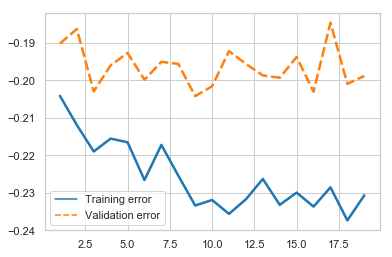

In [4]:
sns.set(style="whitegrid")
log_error_train=[]
log_error_validation=[]

for i in range(20):
    log_error_train.append(math.log10(error_train[i]))
    log_error_validation.append(math.log10(error_validation[i]))


errors = list(zip(log_error_train, log_error_validation))  

errors = pd.DataFrame(errors, columns = ['Training error','Validation error'])
epoch = np.arange(1,21)
data = pd.DataFrame(errors, epoch, columns=["Training error",'Validation error'])


fig = sns.lineplot(data=data, palette="tab10", linewidth=2.5)
fig = fig.get_figure()

fig.savefig("ingalager.png")

In [5]:
# 1 layer 10 neurons

size_data = len(x_train)
size_input_data = len(x_train[0])
size_output_data = len(t_train[0])
number_layers=1
index_output = number_layers + 1
number_neurons=[10]
number_of_epoches = 20
batch_size = 100 
mini_batch_size = int(np.ceil(size_data/batch_size))

#Prepare the data set
cifar10_train = DataSet(x_train,t_train)
x_train = cifar10_train.center_around_zero()

cifar10_test = DataSet(x_test,t_test)
x_test = cifar10_test.center_around_zero()

cifar10_valid = DataSet(x_valid,t_valid)
x_valid = cifar10_valid.center_around_zero()

learning_weights = []
learning_thresholds = []

error_train = []
error_validation = []

classifier = NeuralNetwork(size_input_data, size_output_data,\
                           number_layers, number_neurons)

for epoch in range(number_of_epoches):
    print(f'Epoch {epoch}.')
    x_data = cifar10_train.shuffle_data_set()
    x_train = x_data[0]
    t_train = x_data[1]
    mini_batches = cifar10_train.create_mini_batches(batch_size)
    
    for i in range(mini_batch_size):
        delta = []
        error_times_state = []
        sum_delta=[]
        sum_error_times_states=[]

        states = classifier.calculate_states(x_train)

        for n in range(number_layers +1):

            delta.append([])
            error_times_state.append([])
            sum_delta.append([])
            sum_error_times_states.append([])
            
            for mu in mini_batches[i]:

                delta[n].append(classifier.calculate_error(t_train,
                                                           mu, states)[0][n])
       
                error_times_state[n].append(classifier.calculate_error(t_train,
                                                            mu, states)[1][n])

            sum_delta[n] = np.sum(np.stack(delta[n], axis=0), axis=0)
            sum_error_times_states[n] = np.sum(np.stack(error_times_state[n],
                                                        axis=0), axis=0)

        classifier.update_network(sum_delta,sum_error_times_states)
        
            
   # After each epoch calculate errors

    training_error = classifier.calculate_classification_error(states[index_output], 
                                                               t_train)
    validation_output = classifier.calculate_states(x_valid)[index_output]
    validation_error = classifier.calculate_classification_error(validation_output, 
                                                                 t_valid)
    
    test_output = classifier.calculate_states(x_test)[index_output]
    test_error = classifier.calculate_classification_error(test_output, t_test)

    print(f'Training error:{training_error}, Validation error:{validation_error},\
            Test error:{test_error}')

    error_train.append(training_error)
    error_validation.append(validation_error)
 

Epoch 0.
Training error:0.631675, Validation error:0.6347,            Test error:0.6261
Epoch 1.
Training error:0.6052000000000001, Validation error:0.6181,            Test error:0.622
Epoch 2.
Training error:0.58875, Validation error:0.6079,            Test error:0.6077
Epoch 3.
Training error:0.6009, Validation error:0.6252,            Test error:0.6154000000000001
Epoch 4.
Training error:0.578925, Validation error:0.6116,            Test error:0.611
Epoch 5.
Training error:0.5665, Validation error:0.5951000000000001,            Test error:0.5982000000000001
Epoch 6.
Training error:0.56525, Validation error:0.5962000000000001,            Test error:0.598
Epoch 7.
Training error:0.5748, Validation error:0.6034,            Test error:0.603
Epoch 8.
Training error:0.5619000000000001, Validation error:0.6018,            Test error:0.6
Epoch 9.
Training error:0.5613750000000001, Validation error:0.5972000000000001,            Test error:0.6035
Epoch 10.
Training error:0.55305, Validation 

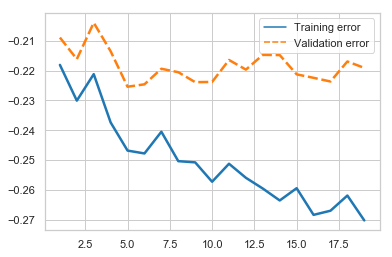

In [6]:
sns.set(style="whitegrid")
log_error_train=[]
log_error_validation=[]

for i in range(20):
    log_error_train.append(math.log10(error_train[i]))
    log_error_validation.append(math.log10(error_validation[i]))


errors = list(zip(log_error_train, log_error_validation))  

errors = pd.DataFrame(errors, columns = ['Training error','Validation error'])
epoch = np.arange(1,21)
data = pd.DataFrame(errors, epoch, columns=["Training error",'Validation error'])


fig = sns.lineplot(data=data, palette="tab10", linewidth=2.5)
fig = fig.get_figure()

fig.savefig("ettlager10.png")